In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization , GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import CSVLogger

In [3]:
from keras.applications import InceptionResNetV2

row_size = 128
col_size = 128

channels = 3
image_shape = (row_size, col_size, channels)
#image_shape = [128, 128]
num_classes = 6


#downloading base_model
base_model= keras.applications.DenseNet201(
                                include_top=False,
                                input_shape=image_shape,
                                weights="imagenet")

In [4]:
base_model.trainable = False

In [5]:
# first we need to run the model in infrence mode to remove the effect of batch norm. then we need to fine tune the model.
################################## this is the key. this freezes all the layers in the model one by one.
for layer in base_model.layers:
	layer.trainable = True
##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
top_model = base_model.output
top_model= GlobalAveragePooling2D()(top_model)
#top_model = Dense(64,activation='relu')(top_model)
top_model = Dropout(0.4)(top_model)
top_model = Dense(num_classes,activation='softmax')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [8]:
batch_size = 16
IMAGE_SIZE = [128, 128]

gen = ImageDataGenerator(rescale=1./255,
      #shear_range=0.2,
      #zoom_range=0.2,
      #vertical_flip=True,
      horizontal_flip=True)

train_path = 'G:\pmx\Arythmia\All_images_balanced'
gen = ImageDataGenerator(validation_split=0.3)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
    subset='training' )

valid_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
    subset='validation' )



Found 33565 images belonging to 6 classes.
Found 14381 images belonging to 6 classes.


In [9]:
filepath = r'G:\pmx\Arythmia\model\dense_net_arr.h5'
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 1,
                              verbose = 1,
                              mode='min')
csv_logger = CSVLogger("dense_net_arr.csv",separator=",", append=True)
#csv_logger = CSVLogger('training.log')

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.1, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True,
                          mode='min')


In [10]:
callbacks_list = [checkpoint , csv_logger, reduce_lr , earlystop]

In [11]:
opt = optimizers.Adam(lr = 1e-5)
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [15]:
history = model.fit(
  train_generator,
  validation_data = valid_generator,
  epochs=10,
  steps_per_epoch=33565//batch_size,
  validation_steps=14381//batch_size , callbacks=callbacks_list)

Epoch 1/10
1048/1048 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9581
Epoch 00001: val_loss improved from 1.52050 to 1.47591, saving model to G:\pmx\Arythmia\model\dense_net_arr.h5
1048/1048 [==============================] - 150s 143ms/step - loss: 0.1336 - accuracy: 0.9581 - val_loss: 1.4759 - val_accuracy: 0.5633
Epoch 2/10
1048/1048 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9683
Epoch 00002: val_loss did not improve from 1.47591

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1048/1048 [==============================] - 133s 127ms/step - loss: 0.1033 - accuracy: 0.9683 - val_loss: 1.7028 - val_accuracy: 0.5528
Epoch 3/10
1048/1048 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9775
Epoch 00003: val_loss did not improve from 1.47591

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
1048/1048 [==============================] - 133s 127ms/s

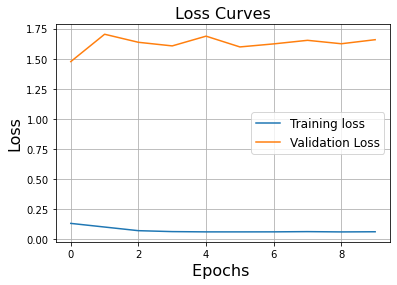

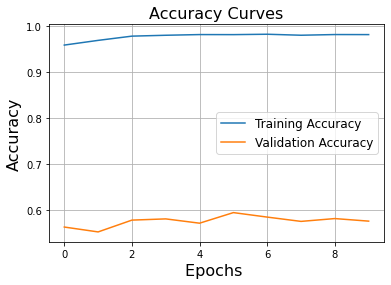

In [16]:
import matplotlib.pyplot as plt
# Loss Curves
#plt.figure(figsize=[10,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.savefig("loss_densenet201.png")
plt.show()
 
# Accuracy Curves
#plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.savefig("acc_densenet201.png")
plt.show()

Found 120 images belonging to 6 classes.
Confusion Matrix
[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  0  0 20  0  0]
 [ 0 10  0  0 10  0]
 [ 0  5  0  0  0 15]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.36      1.00      0.53        20
           2       0.00      0.00      0.00        20
           3       1.00      1.00      1.00        20
           4       1.00      0.50      0.67        20
           5       1.00      0.75      0.86        20

    accuracy                           0.71       120
   macro avg       0.73      0.71      0.68       120
weighted avg       0.73      0.71      0.68       120



C:\Users\sadid\.conda\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sadid\.conda\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sadid\.conda\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


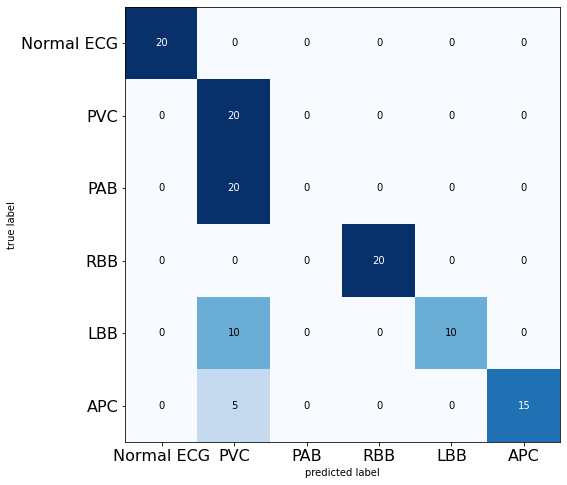

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 
from keras.preprocessing.image import ImageDataGenerator


path = 'G:\pmx\Arythmia\model\Final_2_arr_detection.h5'
#path = 'F:/CA Detection Github/ecg_model_own.hdf5'
model =  load_model(path)
gen = ImageDataGenerator()
IMAGE_SIZE = [128 , 128 ]
batch_size = 32

t_path = 'G:\pmx\Arythmia\Test'

test_generator = gen.flow_from_directory(
  t_path,
  target_size=IMAGE_SIZE,
  shuffle=False)
  #batch_size=batch_size,
    #subset='validation' )

class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


pred = model.predict(test_generator)
pred = np.argmax(pred,axis = 1) 

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, pred, target_names=target_names))


CM = confusion_matrix(test_generator.classes, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 8))
plt.xticks(range(6), ["Normal ECG" , "PVC" , "PAB" , "RBB" , "LBB" , "APC"], fontsize=16)
plt.yticks(range(6), ["Normal ECG" , "PVC" , "PAB" , "RBB" , "LBB" , "APC"], fontsize=16)
#plt.savefig("confusion matrix.png")
plt.show()


In [12]:
history

In [11]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
import pickle 
from keras.preprocessing.image import ImageDataGenerator


path = 'G:\pmx\Arythmia\model\Final_2_arr_detection.h5'
#path = 'F:/CA Detection Github/ecg_model_own.hdf5'
model =  load_model(path)
gen = ImageDataGenerator()
IMAGE_SIZE = [128 , 128 ]
batch_size = 32

t_path = 'G:\pmx\Arythmia\Test'
batch_size = 16
IMAGE_SIZE = [128, 128]

gen = ImageDataGenerator(rescale=1./255,
      #shear_range=0.2,
      #zoom_range=0.2,
      #vertical_flip=True,
      horizontal_flip=True)

train_path = 'G:\pmx\Arythmia\All_images_balanced'
gen = ImageDataGenerator(validation_split=0.3)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
    subset='training' )

valid_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
    subset='validation' )


class_labels = valid_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


pred = model.predict(valid_generator)
pred = np.argmax(pred,axis = 1) 

print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(valid_generator.classes, pred, target_names=target_names))


CM = confusion_matrix(valid_generator.classes, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 8) , normalize=normalize)
plt.xticks(range(6), ["Normal ECG" , "PVC" , "PAB" , "RBB" , "LBB" , "APC"], fontsize=16)
plt.yticks(range(6), ["Normal ECG" , "PVC" , "PAB" , "RBB" , "LBB" , "APC"], fontsize=16)
#plt.savefig("confusion matrix.png")
plt.show()


Found 33565 images belonging to 6 classes.
Found 14381 images belonging to 6 classes.
Confusion Matrix
[[2396    7    0    0    0    0]
 [  41 2358    3    0    1    0]
 [  39 1505  766    4    3   86]
 [   1   15    6 2378    0    6]
 [   4  387    0    1 1967    4]
 [   2   59    1    5    0 2336]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2403
           1       0.54      0.98      0.70      2403
           2       0.99      0.32      0.48      2403
           3       1.00      0.99      0.99      2406
           4       1.00      0.83      0.91      2363
           5       0.96      0.97      0.97      2403

    accuracy                           0.85     14381
   macro avg       0.91      0.85      0.84     14381
weighted avg       0.91      0.85      0.84     14381



NameError: name 'normalize' is not defined